### Processing Pipeline: A series of functions applied to a doc to add attributes like pos tags, dependcy labels, named entites. 

## What happens when you call NLP?


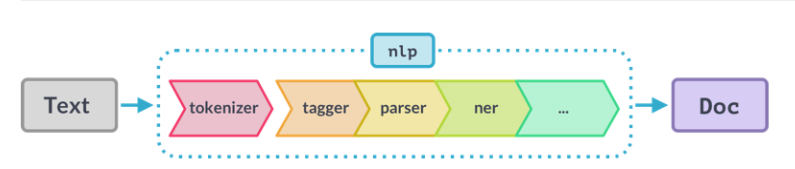

In [1]:
#!pip3 install spacy

In [2]:
#!python3 -m spacy download en_core_web_md

In [3]:
import spacy

nlp = spacy.blank("en") #Creates a blank English nlp object
nlp = spacy.load("en_core_web_md")
doc = nlp("This is a sentence")

In [4]:
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [5]:
print(nlp.pipeline)

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x7fab6c0d63a0>), ('tagger', <spacy.pipeline.tagger.Tagger object at 0x7fab6c0d6dc0>), ('parser', <spacy.pipeline.dep_parser.DependencyParser object at 0x7fab6bcd75f0>), ('attribute_ruler', <spacy.pipeline.attributeruler.AttributeRuler object at 0x7fab6c16c080>), ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer object at 0x7fab6c170c40>), ('ner', <spacy.pipeline.ner.EntityRecognizer object at 0x7fab6bcd7270>)]


## Anatomy of a component

- Function that takes a DOC, modifies it and returns it
- Registerdd using the Language.component decorator
- Can be added using the nlp.add_pipe method

In [6]:
from spacy.language import Language
@Language.component("custom_component")
def custom_component_function(doc):
    #do something to the doc
    return doc
nlp.add_pipe("custom_component")

<function __main__.custom_component_function(doc)>

In [8]:
# Create the nlp object
nlp = spacy.load("en_core_web_md")

# Define a custom component
@Language.component("custom_component")
def custom_component_function(doc):
    # Print the doc's length
    print("Doc length:", len(doc))
    # Return the doc object
    return doc

# Add the component first in the pipeline
nlp.add_pipe("custom_component", first=True)

# Print the pipeline component names
print("Pipeline:", nlp.pipe_names)

Pipeline: ['custom_component', 'tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [9]:
doc = nlp('Hello World!')

Doc length: 3


In [14]:
import spacy
from spacy.language import Language
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span

nlp = spacy.load("en_core_web_md")
animals = ["Golden Retriever", "cat", "turtle", "Rattus norvegicus"]
animal_patterns = list(nlp.pipe(animals))
print("animal_patterns:", animal_patterns)
matcher = PhraseMatcher(nlp.vocab)
matcher.add("ANIMAL", animal_patterns)

# Define the custom component
@Language.component("animal_component")
def animal_component_function(doc):
    # Apply the matcher to the doc
    matches = matcher(doc)
    # Create a Span for each match and assign the label "ANIMAL"
    spans = [Span(doc, start, end, label="ANIMAL") for match_id, start, end in matches]
    # Overwrite the doc.ents with the matched spans
    doc.ents = spans
    return doc


# Add the component to the pipeline after the "ner" component
nlp.add_pipe("animal_component", after="ner")
print(nlp.pipe_names)

# Process the text and print the text and label for the doc.ents
doc = nlp("I have a cat and a Golden Retriever")
print([(ent.text, ent.label_) for ent in doc.ents])

animal_patterns: [Golden Retriever, cat, turtle, Rattus norvegicus]
['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'animal_component']
[('cat', 'ANIMAL'), ('Golden Retriever', 'ANIMAL')]


# Extension Attributes

In [16]:
from spacy.tokens import Doc, Token, Span

#Set extensions on the Doc, Token, and Span
Doc.set_extension("title", default=None)
Token.set_extension("is_color", default=False)
Span.set_extension("has_color", default=False)

### Extension Attribute Types:
1. Attribute Extensions
2. Property Extensions
3. Method Extensions

In [23]:
#1. Attribute Extensions

#Setting a default value that can be overwritten
from spacy.tokens import Token

#Token.set_extension("is_color", default=False)


doc = nlp("The sky is blue")

#Overwrite extension attribute value
doc[3]._.is_color = True

In [27]:
#2. Property Extensions

from spacy.tokens import Token

#Define getter function
def get_is_color(token):
    colors = ["red", "yellow", "blue"]
    return token.text in colors

#Set extensions on the Token with getter
Token.set_extension("is_color", getter=get_is_color, force=True)

doc = nlp("The sky is blue")
print(doc[3]._.is_color, "-", doc[3].text)

True - blue


In [29]:
#2. Property Extensions

from spacy.tokens import Token

#Define getter function
def get_has_color(span):
    colors = ["red", "yellow", "blue"]
    return any(token.text in colors for token in span)

#Set extension on the Span with getter
Span.set_extension("has_color", getter=get_has_color, force=True)

doc = nlp("The sky is blue")
print(doc[1:4]._.has_color, "-", doc[1:4].text)
print(doc[0:2]._.has_color, "-", doc[0:2].text)

True - sky is blue
False - The sky


In [30]:
#3. Method Extnesions
from spacy.tokens import Doc

#Define method with arugments
def has_token(doc, token_text):
    in_doc = token_text in [token.text for token in doc]
    return in_doc

#Set extension on the Doc with method
Doc.set_extension("has_token", method=has_token, force=True)

doc = nlp("The sky is blue.")
print(doc._.has_token("blue"), "- blue")
print(doc._.has_token("clud"), "- cloud")

True - blue
False - cloud


In [31]:
import spacy
from spacy.tokens import Span

nlp = spacy.blank("en")

# Define the method
def to_html(span, tag):
    # Wrap the span text in a HTML tag and return it
    return f"<{tag}>{span.text}</{tag}>"


# Register the Span method extension "to_html" with the method to_html
Span.set_extension("to_html", method=to_html)

# Process the text and call the to_html method on the span with the tag name "strong"
doc = nlp("Hello world, this is a sentence.")
span = doc[0:2]
print(span._.to_html("strong"))

<strong>Hello world</strong>


# Scaling and Performance

In [32]:
data = [
    ("This is a text", {"id": 1, "page_number": 15}),
    ("And another text", {"id": 2, "page_number": 16}),
]

In [33]:
for doc, context in nlp.pipe(data, as_tuples=True):
    print(doc.text, context["page_number"])

This is a text 15
And another text 16


In [34]:
from spacy.tokens import Doc

Doc.set_extension("id", default=None, force=True)
Doc.set_extension("page_number", default=None, force=True)

for doc, context in nlp.pipe(data, as_tuples=True):
    doc._.id = context["id"]
    doc._.page_number = context["page_number"]

In [35]:
doc = nlp.make_doc("Hello World!")

In [40]:
import spacy

nlp = spacy.load("en_core_web_md")
text = (
    "Chick-fil-A is an American fast food restaurant chain headquartered in "
    "the city of College Park, Georgia, specializing in chicken sandwiches."
)

# Only tokenize the text
doc = nlp.make_doc(text)
print([token.text for token in doc])

['Chick', '-', 'fil', '-', 'A', 'is', 'an', 'American', 'fast', 'food', 'restaurant', 'chain', 'headquartered', 'in', 'the', 'city', 'of', 'College', 'Park', ',', 'Georgia', ',', 'specializing', 'in', 'chicken', 'sandwiches', '.']


In [43]:
import spacy

nlp = spacy.load("en_core_web_md")
text = (
    "Chick-fil-A is an American fast food restaurant chain headquartered in "
    "the city of College Park, Georgia, specializing in chicken sandwiches."
)

# Disable the tagger and lemmatizer
with nlp.select_pipes(disable=["tagger", "lemmatizer"]):
    # Process the text
    doc = nlp(text)
    # Print the entities in the doc
    print(doc.ents)

(American, College Park, Georgia)
